In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM  # perform F test


import cortico_cereb_connectivity.scripts.script_train_eval_models as ste

import warnings
warnings.filterwarnings('ignore')

# Determine the best models to be fused
These are determined on a dataset specific manner?

In [3]:
# get the best performing model for Md_ses-s1, L1 and L2 regression
dfs1=rm.comb_eval(models=['Md-loo', 'Md_ses-s1-loo', 'Ni-loo', 'Ib-loo', 'So-loo', 'De-loo'],
                  eval_t = 'eval', 
                  eval_data=["MDTB", "Nishimoto", "Demand", "Somatotopic", "IBC"], 
                  methods =['L2regression', 'L1regression'])
dfs1['model'].fillna('avg',inplace=True)
dfs1['nanY']=np.isnan(dfs1.noiseceiling_Y)
dfs1['nanXY']=np.isnan(dfs1.noiseceiling_XY)
dfs1['nanXR']=np.isnan(dfs1.noise_X_R)
print(dfs1.train_dataset.unique())
print(dfs1.eval_dataset.unique())

# check this out, it'll be empty
print(dfs1.loc[dfs1.train_dataset != dfs1.eval_dataset])

['MDTB' 'Nishimoto' 'Demand' 'Somatotopic' 'IBC']
['MDTB' 'Nishimoto' 'Demand' 'Somatotopic' 'IBC']
Empty DataFrame
Columns: [eval_subj, num_regions, train_dataset, train_ses, train_type, cerebellum, cortex, method, logalpha, R_train, rmse_train, R_cv, rmse_cv, eval_dataset, eval_ses, parcellation, crossed, add_rest, splitby, type, cv_fold, model, R_eval, R2_eval, noise_Y_R, noise_Y_R2, noise_X_R, noise_X_R2, noiseceiling_Y, noiseceiling_XY, R_eval_adj, nanY, nanXY, nanXR]
Index: []

[0 rows x 34 columns]


In [4]:
# determine the best logalpha for each regularization method
## for L1 regression
ds_L1 = dfs1.loc[dfs1.method=='L1regression']
A_L1 = pd.pivot_table(ds_L1,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L1 = np.nan_to_num(A_L1.values)
ind_L1 = B_L1.argmax(axis=1)
log_a_L1=np.array(A_L1.columns.get_level_values(1)[ind_L1])
bestla_L1 = pd.DataFrame(log_a_L1,index=A_L1.index,columns=['best_logalpha'])
ds_L1['isbest'] = ds_L1.logalpha.values  == bestla_L1.loc[ds_L1.train_dataset].values.flatten()

## for L2 regression
ds_L2 = dfs1.loc[dfs1.method=='L2regression']
A_L2 = pd.pivot_table(ds_L2,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L2 = np.nan_to_num(A_L2.values)
ind_L2 = B_L2.argmax(axis=1)
log_a_L2=np.array(A_L2.columns.get_level_values(1)[ind_L2])
bestla_L2 = pd.DataFrame(log_a_L2,index=A_L2.index,columns=['best_logalpha'])
ds_L2['isbest'] = ds_L2.logalpha.values  == bestla_L2.loc[ds_L2.train_dataset].values.flatten()

## Evaluate L1 models

MDTB: best alpha = -5
Nishimoto: best alpha = -4
IBC: best alpha = -5
Demand: best alpha = -4
Somatotopic: best alpha = -3


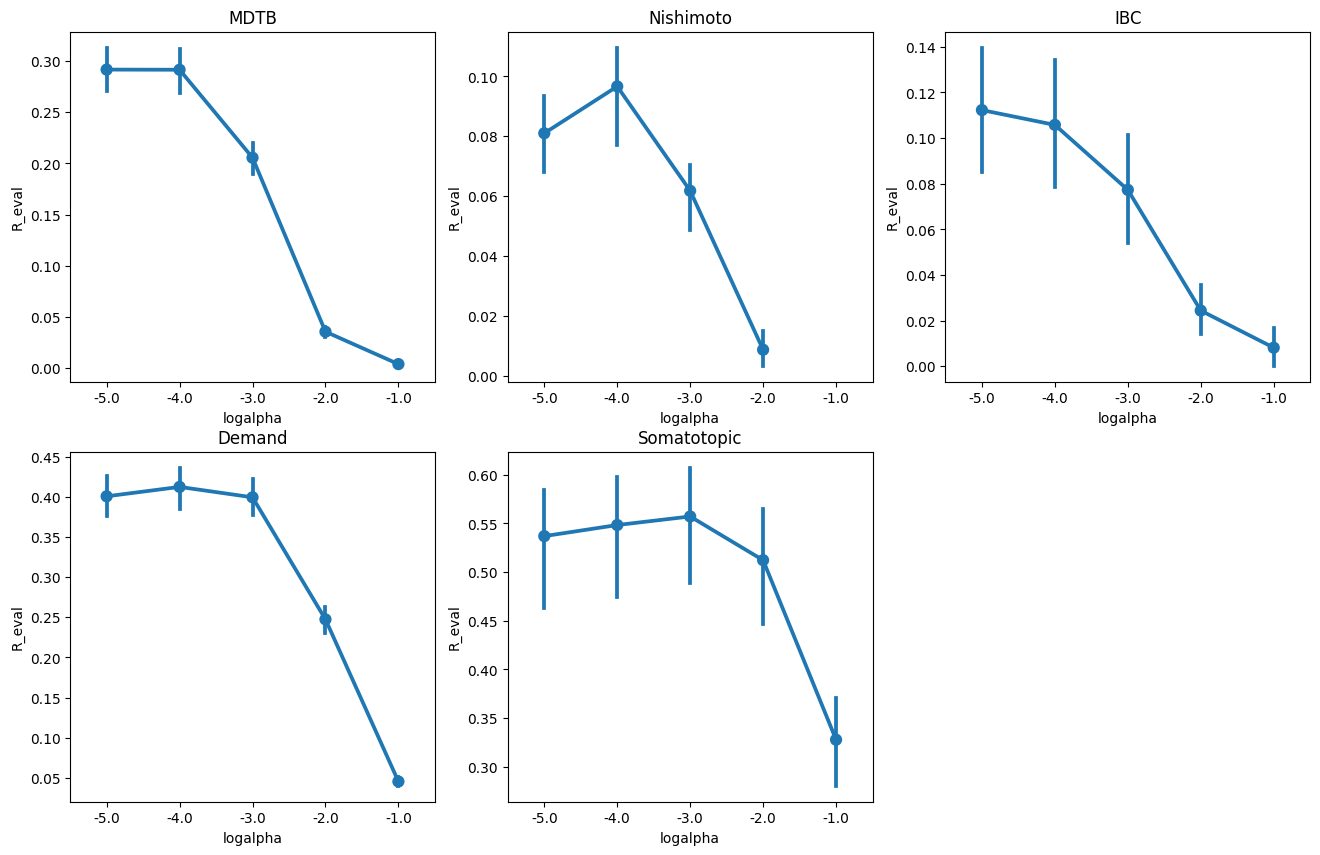

In [5]:
plt.figure(figsize=(16,10))
evd=['MDTB','Nishimoto','IBC','Demand','Somatotopic']

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=ds_L1[(ds_L1.eval_dataset==ed) & (ds_L1.train_dataset==ed)]
    plt.title(ed)
    sns.pointplot(data=d,y='R_eval',x='logalpha')
    # get the logalpha corresponding to best performance
    best_alpha = bestla_L1.loc[ed].values[0].astype(int)
    print(f"{ed}: best alpha = {best_alpha}")


## Evaluate L2 models

MDTB: best alpha = 8
Nishimoto: best alpha = 10
IBC: best alpha = 6
Demand: best alpha = 6
Somatotopic: best alpha = 6


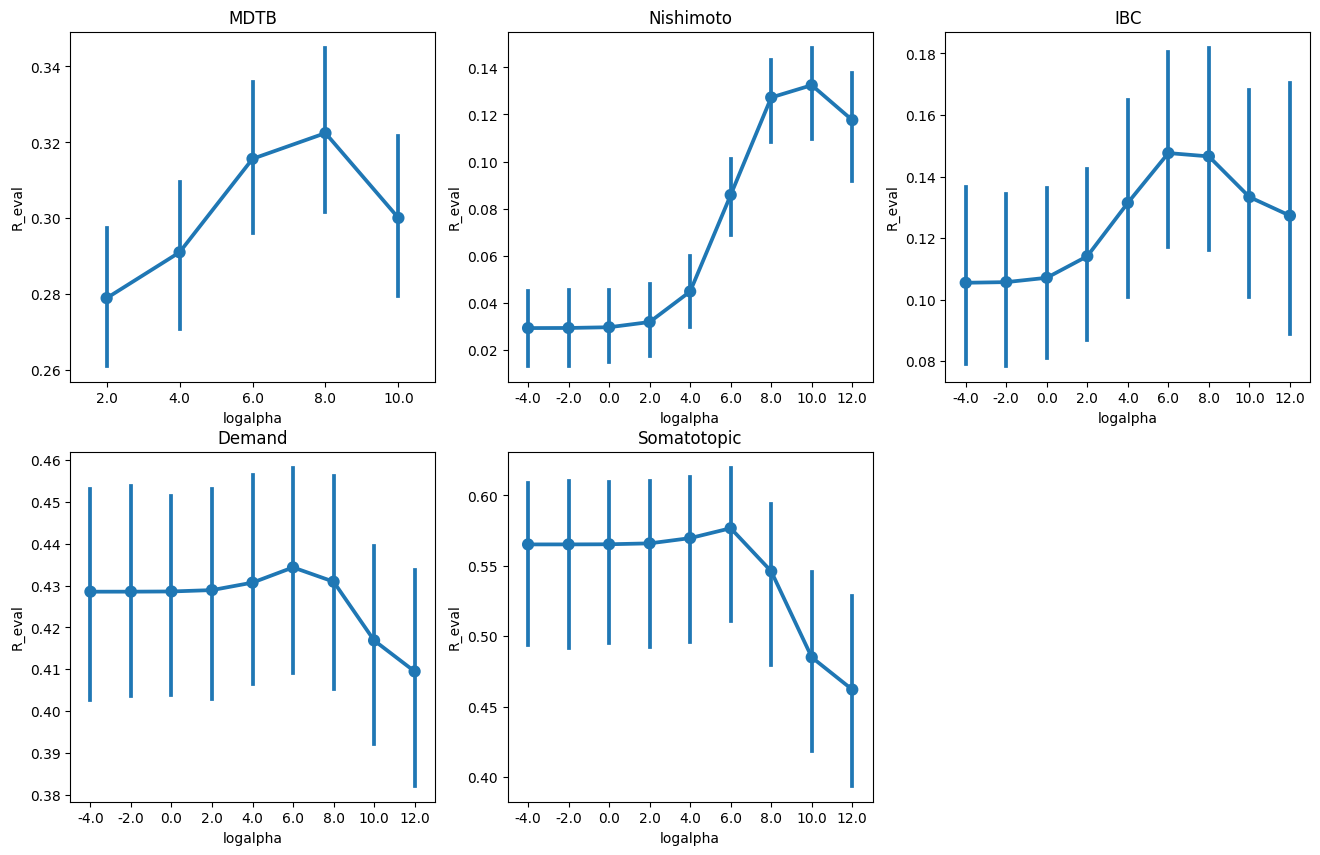

In [6]:
plt.figure(figsize=(16,10))
evd=['MDTB','Nishimoto','IBC','Demand','Somatotopic']

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=ds_L2[(ds_L2.eval_dataset==ed) & (ds_L2.train_dataset==ed)]
    plt.title(ed)
    sns.pointplot(data=d,y='R_eval',x='logalpha')
    # get the logalpha corresponding to best performance
    best_alpha = bestla_L2.loc[ed].values[0].astype(int)
    print(f"{ed}: best alpha = {best_alpha}")


##  Evaluate different models
Fusion9: ['Demand'','IBC','MDTB','Somatotopic','Nishimoto'],

MDTB:['ses-s1'], This is the connectivity model we used in the connectivity paper

MDTB:['ses-s1', 'ses-s2'] The connectivity weights will be averaged over ses-s1 and ses-s2

For each of the models, both Ridge and lasso regression will be considered


# What is the best performing model trained only on ses-s1 for MDTB

## getting models trained on MDTB 
These will be the models trained on MDTB, either set A tasks or both set A and set B

In [8]:
D_Md_s1 = dfs1.loc[(dfs1.train_dataset=='MDTB')&(dfs1.train_ses == 'ses-s1')]
D_Md_s1.columns

Index(['eval_subj', 'num_regions', 'train_dataset', 'train_ses', 'train_type',
       'cerebellum', 'cortex', 'method', 'logalpha', 'R_train', 'rmse_train',
       'R_cv', 'rmse_cv', 'eval_dataset', 'eval_ses', 'parcellation',
       'crossed', 'add_rest', 'splitby', 'type', 'cv_fold', 'model', 'R_eval',
       'R2_eval', 'noise_Y_R', 'noise_Y_R2', 'noise_X_R', 'noise_X_R2',
       'noiseceiling_Y', 'noiseceiling_XY', 'R_eval_adj', 'nanY', 'nanXY',
       'nanXR'],
      dtype='object')

In [9]:
# determine the best logalpha for each regularization method
## for L1 regression
ds_L1 = D_Md_s1.loc[D_Md_s1.method=='L1regression']
A_L1 = pd.pivot_table(ds_L1,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L1 = np.nan_to_num(A_L1.values)
ind_L1 = B_L1.argmax(axis=1)
log_a_L1=np.array(A_L1.columns.get_level_values(1)[ind_L1])
bestla_L1 = pd.DataFrame(log_a_L1,index=A_L1.index,columns=['best_logalpha'])
ds_L1['isbest'] = ds_L1.logalpha.values  == bestla_L1.loc[ds_L1.train_dataset].values.flatten()

## for L2 regression
ds_L2 = D_Md_s1.loc[D_Md_s1.method=='L2regression']
A_L2 = pd.pivot_table(ds_L2,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L2 = np.nan_to_num(A_L2.values)
ind_L2 = B_L2.argmax(axis=1)
log_a_L2=np.array(A_L2.columns.get_level_values(1)[ind_L2])
bestla_L2 = pd.DataFrame(log_a_L2,index=A_L2.index,columns=['best_logalpha'])
ds_L2['isbest'] = ds_L2.logalpha.values  == bestla_L2.loc[ds_L2.train_dataset].values.flatten()

In [21]:
D_Md = dfs1.loc[(dfs1.train_dataset=='MDTB')&(dfs1.train_ses == 'all')]

In [22]:
# determine the best logalpha for each regularization method
# for L1 regression
d_L1 = D_Md.loc[D_Md.method=='L1regression']
A_L1 = pd.pivot_table(d_L1,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L1 = np.nan_to_num(A_L1.values)
ind_L1 = B_L1.argmax(axis=1)
log_a_L1=np.array(A_L1.columns.get_level_values(1)[ind_L1])
bestla_L1 = pd.DataFrame(log_a_L1,index=A_L1.index,columns=['best_logalpha'])
d_L1['isbest'] = d_L1.logalpha.values  == bestla_L1.loc[d_L1.train_dataset].values.flatten()

# for L2 regression
d_L2 = D_Md.loc[D_Md.method=='L2regression']
A_L2 = pd.pivot_table(d_L2,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L2 = np.nan_to_num(A_L2.values)
ind_L2 = B_L2.argmax(axis=1)
log_a_L2=np.array(A_L2.columns.get_level_values(1)[ind_L2])
bestla_L2 = pd.DataFrame(log_a_L2,index=A_L2.index,columns=['best_logalpha'])
d_L2['isbest'] = d_L2.logalpha.values  == bestla_L2.loc[d_L2.train_dataset].values.flatten()

# prep for comparing models


# Now get the fused model


In [13]:
# Add the favorite Fusion model
dfuse = rm.comb_eval(models=['Fu09-loo'],eval_t = 'eval', methods=['L1regression', 'L2regression'])


<AxesSubplot: ylabel='R_eval'>

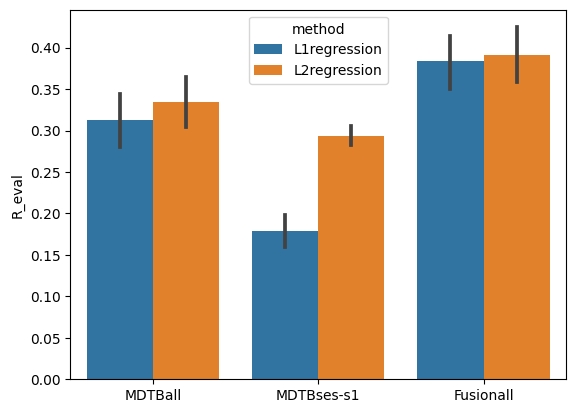

In [14]:
# concatenate the two dataframes
dall = pd.concat([D_Md, D_Md_s1,dfuse],ignore_index=True)
sns.barplot(data=dall,x=dall['train_dataset'] + dall['train_ses'],y='R_eval', hue = "method")


In [16]:
# What predicition accuracy relative to noise-ceiling? Fusion L2regression
dd = dall.loc[(dall.train_dataset == 'Fusion') & (dall.method == 'L2regression')]
print(f"R_eval {dd.R_eval.mean():.4f} + {dd.R_eval.std():.2f}")
adj = dd.R_eval.mean() / dd.noiseceiling_XY.mean() 
print(f"R_eval {adj:.4f} ") 
print(f'Average noiseceiling{dd.noiseceiling_XY.mean():.4f} ')
print(f'variance predicted:{adj**2:.4f}')

R_eval 0.3906 + 0.17
R_eval 0.6698 
Average noiseceiling0.5832 
variance predicted:0.4487


In [17]:
# What predicition accuracy relative to noise-ceiling? Fusion L1regression
dd = dall.loc[(dall.train_dataset == 'Fusion') & (dall.method == 'L1regression')]
print(f"R_eval {dd.R_eval.mean():.4f} + {dd.R_eval.std():.2f}")
adj = dd.R_eval.mean() / dd.noiseceiling_XY.mean() 
print(f"R_eval {adj:.4f} ") 
print(f'Average noiseceiling{dd.noiseceiling_XY.mean():.4f} ')
print(f'variance predicted:{adj**2:.4f}')

R_eval 0.3842 + 0.17
R_eval 0.6666 
Average noiseceiling0.5764 
variance predicted:0.4444


## a different approach:
Evaluating the models trained on different datasets on the dataset in the current paper

** The fused model used here excludes the current dataset

Alternatively, we can set WMFS aside completely and use another dataset for evaluation, like Demand

In [44]:
# get the best performing model for Md_ses-s1, L1 and L2 regression
dfs1=rm.comb_eval(models=['Md', 'Md_ses-s1', 'Ni', 'Ib', 'So', 'De', 'Wm-loo', 'Fu09-loo'],
                  eval_t = 'eval', 
                  eval_data=["WMFS"], 
                  methods =['L2regression', 'L1regression'])
dfs1['model'].fillna('avg',inplace=True)
dfs1['nanY']=np.isnan(dfs1.noiseceiling_Y)
dfs1['nanXY']=np.isnan(dfs1.noiseceiling_XY)
dfs1['nanXR']=np.isnan(dfs1.noise_X_R)
print(dfs1.train_dataset.unique())
print(dfs1.eval_dataset.unique())
# dfs1.loc[dfs1.train_dataset != dfs1.eval_dataset]

['MDTB' 'Nishimoto' 'IBC' 'Somatotopic' 'Demand' 'WMFS' 'Fusion']
['WMFS']


In [45]:
# for all the non-fused models, get the best performing model
# determine the best logalpha for each regularization method
DD_fuse = dfs1.loc[dfs1.train_dataset == 'Fusion']
DD = dfs1.loc[dfs1.train_dataset != 'Fusion']
## for L1 regression
ds_L1 = DD.loc[DD.method=='L1regression']
A_L1 = pd.pivot_table(ds_L1,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L1 = np.nan_to_num(A_L1.values)
ind_L1 = B_L1.argmax(axis=1)
log_a_L1=np.array(A_L1.columns.get_level_values(1)[ind_L1])
bestla_L1 = pd.DataFrame(log_a_L1,index=A_L1.index,columns=['best_logalpha'])
ds_L1['isbest'] = ds_L1.logalpha.values  == bestla_L1.loc[ds_L1.train_dataset].values.flatten()

## for L2 regression
ds_L2 = DD.loc[DD.method=='L2regression']
A_L2 = pd.pivot_table(ds_L2,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B_L2 = np.nan_to_num(A_L2.values)
ind_L2 = B_L2.argmax(axis=1)
log_a_L2=np.array(A_L2.columns.get_level_values(1)[ind_L2])
bestla_L2 = pd.DataFrame(log_a_L2,index=A_L2.index,columns=['best_logalpha'])
ds_L2['isbest'] = ds_L2.logalpha.values  == bestla_L2.loc[ds_L2.train_dataset].values.flatten()

In [47]:
# get the best performing models, L1 and L2 regression
DD_L1 = ds_L1[ds_L1['isbest']]
DD_L2 = ds_L2[ds_L2['isbest']]

# concatenate the two dataframes
dall = pd.concat([DD_L1, DD_L2],ignore_index=True)

# concatenate it to the fused model
dall = pd.concat([DD_fuse, dall],ignore_index=True)

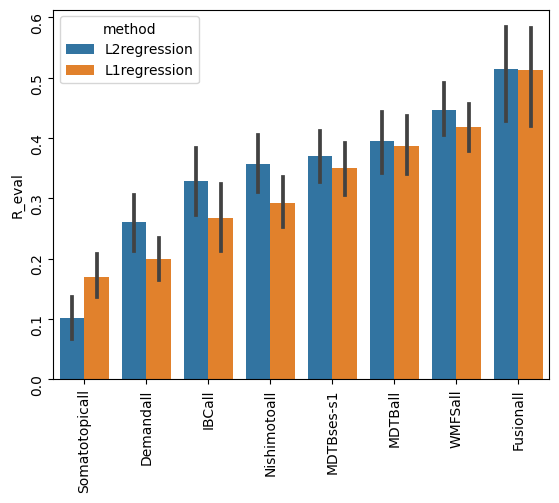

In [52]:
# order = ["Demandall", "MDTBall", "MDTBses-s1", "Nishimotoall", "IBCall", "Somatotopicall", "Fusionall"]
order = ["Somatotopicall", "Demandall", "IBCall", "Nishimotoall" , "MDTBses-s1", "MDTBall", "WMFSall", "Fusionall"]
# sns.pointplot(data=dall,x=dall['train_dataset'] + dall['train_ses'],y='R_eval', hue = "method", order = order)
ax = sns.barplot(data=dall,x=dall['train_dataset'] + dall['train_ses'],y='R_eval', hue = "method", order = order)
# Rotate the x-axis tick labels
ax.tick_params(labelrotation=90)

plt.show()

In [54]:
# is the fused model better than the model trained on WMFS?
t=stats.ttest_rel(dall[dall['train_dataset']=='Fusion']['R_eval'],
                  dall[dall['train_dataset']=='WMFS']['R_eval']) 
indx =dall['train_dataset']=='WMFS'
df=indx.sum()-1
print(f't({df}) = {t.statistic:.3f}, p={t.pvalue:.4e}')

t(31) = 4.059, p=3.1014e-04
